In [1]:
%matplotlib inline
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Visualization

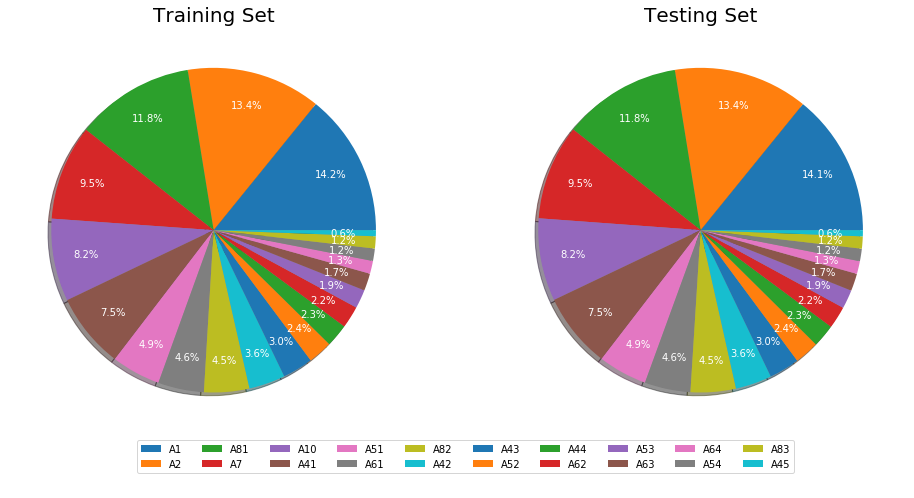

In [2]:
fig = plt.figure(figsize=(16,8))
for subid, data, title in zip([121,122],[train,test], ['Training Set', 'Testing Set']):
    axes = fig.add_subplot(subid)
    axes.set_title(title, fontdict={'fontsize':20})
    qs = data['Question'].value_counts().to_dict()
    patches, _, _ = axes.pie(list(qs.values()), autopct='%1.1f%%', shadow=True, pctdistance=0.8,
                            textprops={'color':'white', 'size':10})
_ = plt.figlegend(patches, list(qs.keys()), loc=(0.15, 0.05), ncol=10)

In [3]:
train['abs_len'] = train['Abs'].apply(lambda x: len(x.split()))
train['ans_len'] = train['Answer'].apply(lambda x: len(x.split()))
test['abs_len'] = test['Abs'].apply(lambda x: len(x.split()))
test['ans1_len'] = test['Ans1'].apply(lambda x: len(x.split()))
test['ans2_len'] = test['Ans2'].apply(lambda x: len(x.split()))

In [4]:
train.describe()

,abs_len,ans_len
count,11470.000000,11470.000000
mean,157.803313,12.863906
std,45.556566,9.535285
min,17.000000,1.000000
25%,128.000000,6.000000
50%,157.000000,11.000000
75%,185.000000,17.000000
max,385.000000,163.000000


In [5]:
test.describe()

,Id,abs_len,ans1_len,ans2_len
count,4927.000000,4927.000000,4927.000000,4927.000000
mean,2464.000000,158.294094,12.868277,12.868074
std,1422.446718,45.167085,9.374137,9.361858
min,1.000000,18.000000,1.000000,1.000000
25%,1232.500000,129.000000,6.000000,6.000000
50%,2464.000000,158.000000,11.000000,11.000000
75%,3695.500000,186.000000,17.000000,17.000000
max,4927.000000,385.000000,97.000000,98.000000


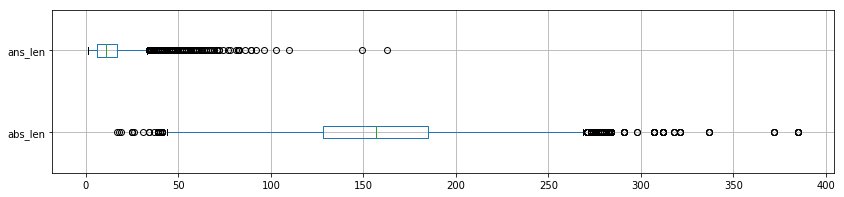

In [6]:
_ = train.boxplot(column=['abs_len', 'ans_len'], figsize=(14,3), vert=False)

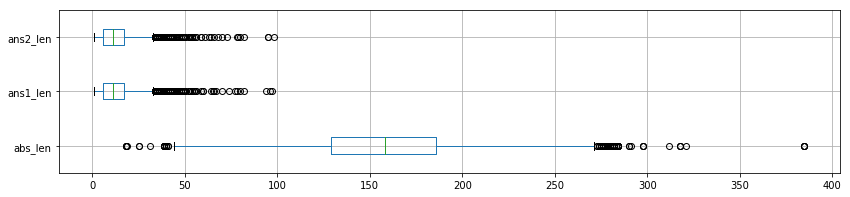

In [7]:
_ = test.boxplot(column=['abs_len', 'ans1_len', 'ans2_len'], figsize=(14,3), vert=False)

# Prepare id-question mapping

In [8]:
with open('data/QAmapping.md', encoding='utf8', errors='ignore') as f:
    r = f.read()
chinese = re.compile(r'[\u0391-\uFFE5]+')
r = re.sub(chinese, '', r)
pattern = re.compile(r'(Q[0-9]+)\nQ:(.*?)\n((?:A[0-9]+[\n]*)+)', re.DOTALL)
content = re.compile(r'.+\?')
id2q = {}
for q in re.findall(pattern, r):
    cont = re.findall(content, q[1])
    for id in q[-1].split('\n'):
        if len(id) >= 1:
            id2q[id] = cont[0].strip()
for k,v in id2q.items():
    print('{}: {}'.format(k, v))

A1: What is the objective/aim of this paper?
A2: What problem(s) does this paper address?
A41: What method/approach does this paper propose?
A51: What is this method based on?
A61: How does the proposed method differ from previous methods/approaches?
A42: What model does this paper propose?
A52: What is this model based on?
A62: How does the proposed model differ from previous models?
A43: What algorithm does this paper propose?
A53: What is this algorithm based on?
A63: How does the proposed algorithm differ from previous algorithms?
A44: What framework does this paper propose?
A54: What is this framework based on?
A64: How does the proposed framework differ from previous frameworks?
A45: What datasetdoes this paper propose?
A7: What experiment does this paper carry out to evaluate the result?
A81: What does the result of this paper show(demonstrated by the experiment)?
A82: What does the result of this paper show(demonstrated by the experiment)?
A83: What does the result of this pape

# Convert the dataset to the form of SQuAD

In [9]:
train.head()

,Question,Abs,Answer,abs_len,ans_len
0,A1,To capture the inherent geometric features of ...,To capture the inherent geometric features of ...,191,11
1,A1,It has been shown recently that the performanc...,"In this work, we address this problem but usi...",146,19
2,A1,This paper studies the problem of learning nod...,learning node embeddings (a.k.a. distributed r...,110,9
3,A1,We consider a graph of interconnected agents i...,consider a graph of interconnected agents imp...,72,20
4,A1,Video caption refers to generating a descripti...,"However, most of the existing methods focus mo...",196,17


In [10]:
data_train = []
cnt = 0
train_dict = train.to_dict('records')
for item in train_dict:
    context = item['Abs']
    ans_text = item['Answer']
    ans_text = ans_text.replace('\t', r'\t')
    ans_text = ans_text.replace('$mu$', r'$\mu$')
    ans_text = ans_text.replace(r'$\tilde{O}(frac{n}{mu^2}+k^2)$', r'$\tilde{O}(\frac{n}{\mu^2}+k^2)$')
    qas = [{
        'question':id2q[item['Question']], 
        'id':cnt, 
        'answers':[{
            'test':ans_text, 
            'ans_start':context.find(ans_text),
        }], 
        'is_impossible':False,
    }]
    paragraphs = [{
        'context':context,
        'qas':qas,
    }]
    data_train.append({
        'paragraphs':paragraphs,
        'title':cnt,
    })
    cnt += 1
dataset_train = {'data':data_train, 'version':'1.1'}
dataset_train['data'][0]

{'paragraphs': [{'context': 'To capture the inherent geometric features of many community detection problems, we propose to use a new random graph model of communities that we call a Geometric Block Model. The geometric block model generalizes the random geometric graphs in the same way that the well-studied stochastic block model generalizes the Erdös-Renyi random graphs. It is also a natural extension of random community models inspired by the recent theoretical and practical advancement in community detection. While being a topic of fundamental theoretical interest, our main contribution is to show that many practical community structures are better explained by the geometric block model. We also show that a simple triangle-counting algorithm to detect communities in the geometric block model is near-optimal. Indeed, even in the regime where the average degree of the graph grows only logarithmically with the number of vertices (sparse-graph), we show that this algorithm performs ext

In [11]:
test.head()

,Id,Question,Abs,Ans1,Ans2,abs_len,ans1_len,ans2_len
0,1,A83,"Grid pathfinding, an old AI problem, is centra...",central for the development of navigation syst...,a configuration of our A*-based implementation...,192,26,25
1,2,A82,"We introduce the problem Max#SAT, an extension...","Max#SAT has applications in many areas,",to an NP oracle can approximate the,152,6,7
2,3,A10,Vehicle re-identification (re-ID) is to identi...,but neglect the discrimination between vehicle...,both intra-class compactness and inter-class ...,184,23,23
3,4,A1,The pattern satisfiability is a fundamental pr...,a complete analysis of decidability/undecidab...,of SPARQL 1.1 without expressing both AND and ...,74,12,13
4,5,A2,How do people describe clothing? The words lik...,bridge the gap between the visual features and...,"words like “formal”or ""casual"" are usually use...",199,11,11


In [12]:
data_test = []
cnt = 0
test_dict = test.to_dict('records')
for item in test_dict:
    context = item['Abs']
    ans_text1 = item['Ans1']
    ans_text1 = ans_text1.replace('\t', r'\t')
    ans_text1 = ans_text1.replace('{em', r'{\em')
    ans_text2 = item['Ans2']
    ans_text2 = ans_text2.replace('\t', r'\t')  
    ans_text2 = ans_text2.replace('{em', r'{\em')
    qas = [{
        'question':id2q[item['Question']], 
        'id':item['Id'], 
        'answers':[
            {
            'test':ans_text1, 
            'ans_start':context.find(ans_text1),
            },
            {
            'test':ans_text2, 
            'ans_start':context.find(ans_text2),
            },  
        ], 
        'is_impossible':False,
    }]
    paragraphs = [{
        'context':context,
        'qas':qas,
    }]
    data_test.append({
        'paragraphs':paragraphs,
        'title':cnt,
    })
    cnt += 1
dataset_test = {'data':data_test, 'version':'1.1'}
dataset_test['data'][0]

{'paragraphs': [{'context': 'Grid pathfinding, an old AI problem, is central for the development of navigation systems for autonomous agents. A surprising fact about the vast literature on this problem is that very limited neighborhoods have been studied. Indeed, only the 4- and 8-neighborhoods are usually considered, and rarely the 16-neighborhood. This paper describes three contributions that enable the construction of effective grid path planners for extended 2k-neighborhoods. First, we provide a simple recursive definition of the 2k-neighborhood in terms of the 2k–1-neighborhood. Second, we derive distance functions, for any k >1, which allow us to propose admissible heurisitics which are perfect for obstacle-free grids. Third, we describe a canonical ordering which allows us to implement a version of A* whose performance scales well when increasing k. Our empirical evaluation shows that the heuristics we propose are superior to the Euclidean distance (ED) when regular A* is used. 